In [1]:
import numpy as np
import torch 
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os
import random
import copy
from collections import defaultdict

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


## 1. Data Preprocessing

In [3]:
def preprocessing(main_folder_path):
    # list of folders in the main folder
    listdir = sorted(os.listdir(main_folder_path))
    
    # Image Transformation
    mean = [0.485, 0.456, 0.406] # mean of image tensor
    std = [0.229, 0.224, 0.225]  # standard devisation of image tensor
    normalize_stat = (mean, std)
    size = 224

    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(*normalize_stat)
    ])

    dataset = ImageFolder(main_folder_path, transform=transform)
    classes = dataset.classes

    return dataset, classes

In [4]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)

print("Total dataset size: ", len(dataset))
print("Number of classes: ", len(classes))

Total dataset size:  17534
Number of classes:  105


In [5]:
def dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients):
    torch.manual_seed(42)
    
    # 70% to 30% train to test
    num_val = int(len(dataset) * 0.3)
    num_train = len(dataset) - num_val
    
    # 1. Train and Validation Data
    train_data, test_data = random_split(dataset, [num_train, num_val])
    
    # save train_data size (n)
    n = len(train_data)
    
    # Partition data for federated learning
    train_loader_list = []
    
    # nk / n list
    nk_n_list = []
    
    # Client ID: corresponding train_loader
    client_loader_dict = {}
    
    # Split train dataset
    total_train_size = len(train_data)
    examples_per_client = total_train_size // num_clients
    client_datasets = random_split(train_data, [min(i + examples_per_client, 
               total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
    
    client_datasets = client_datasets[:num_clients]
    
    
    # Save dataloader for each
    for client_id, client_data in enumerate(client_datasets):
        
        # Save nk / n
        nk_n = len(client_data) / len(train_data)
        nk_n_list.append(nk_n)
        
        train_loader = DataLoader(client_data, batch_size=train_batch_size, shuffle=True, pin_memory=False, num_workers=3)
        train_loader_list.append(train_loader)
        client_loader_dict[client_id] = train_loader
    
    # Train and Validation Dataloader
    loader_idx = 0
    for key, _ in client_loader_dict.items():
        client_loader_dict[key] = train_loader_list[loader_idx]
        loader_idx += 1
    
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, pin_memory=False, num_workers=3)
    
    return train_loader_list, client_loader_dict, test_loader, test_data, nk_n_list

In [6]:
num_clients = 5
train_batch_size = 64
test_batch_size = 32

train_loader_list, client_loader_dict, test_loader, test_data, nk_n_list = dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients)

for i in nk_n_list:
    print(i)

0.19993482157405898
0.19993482157405898
0.19993482157405898
0.19993482157405898
0.19993482157405898


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2. Model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from glob import glob
from tqdm.notebook import tqdm

In [8]:
class black_box_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet34 = models.resnet34(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet34.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [9]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)

global_model = black_box_model(num_classes=num_classes).to(device)
# global_model.summary((3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## 3. Federated Learning

In [10]:
# # Federated Averaging Algorithm (Non-IID)
# def fedAvg(w, nk_n_list, client_id_selected):
    
#     print("")
#     print("Averaging client_id list: ", client_id_selected)
    
#     first_id = client_id_selected[0]
#     w_avg = copy.deepcopy(w[first_id])
    
#     # Update first weight parameter
#     for k in w_avg.keys():
#         nk_n = nk_n_list[first_id]
#         w_avg[k] = w_avg[k] + (nk_n * w[first_id][k])
    
#     # Remove the updated id weight
#     client_id_selected.remove(first_id)
    
#     print("After removing first index: ", client_id_selected)
#     print("")
    
#     # Use selected client's weight parameters
#     for k in w_avg.keys():
#         for i in client_id_selected: 
#             nk_n = nk_n_list[i]
#             w_avg[k] = w_avg[k] + (nk_n * w[i][k])
        
#         w_avg[k] = torch.div(w_avg[k], len(w))
    
#     return w_avg

In [48]:
# FedAvg (iid-data)

from collections import OrderedDict

def fedAvg(client_model_list):
    new_params = OrderedDict()
    
    n = len(client_model_list)  # number of clients
    
    for client_model in client_model_list:
        local_param = client_model.state_dict()  # get current parameters of one client
        for k, v in local_param.items():
            new_params[k] = new_params.get(k, 0) + v / n
    
    return new_params

## 4. Train and Evaluate

In [12]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# Code Referance: https://www.kaggle.com/code/pezhmansamadi/facerecognition-torch-resnet34

def local_train(e, local_epochs, local_model, train_loader, device, criterion, optimizer):
    torch.cuda.empty_cache()
    local_model.train(True)
    torch.set_grad_enabled(True)
    
    total = 0
    correct = 0
    local_loss = 0.0
    local_acc = 0
    
    tq_batch = tqdm(train_loader, total=len(train_loader))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = local_model(images)
        _, preds = torch.max(outs, 1)
        
        # outs = torch.exp(outs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        local_loss += loss.item()
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        local_acc += float(correct) / total
        
        tq_batch.set_description(f'Local Epoch [{e + 1}/{local_epochs}]')
        tq_batch.set_postfix_str('Local loss = {:.4f} ; Local acc = {:.4f} '.format(loss.item(), float(correct) / total))
    
    # Average loss and acc of the training batch
    local_acc = local_acc / len(train_loader)
    local_loss = local_loss / len(train_loader)
    local_w = local_model.state_dict()

    return local_model, local_loss, local_w, local_acc

def global_evaluate(global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    glob_loss = 0
    glob_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        glob_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)

    return glob_acc, glob_loss

In [13]:
def federated_learning(num_selected, num_rounds, num_clients, num_local_epochs, global_model, client_model_list, client_loader_dict, device):
    torch.cuda.empty_cache()
    
    id_loss_dict = defaultdict(list)
    id_acc_dict = defaultdict(list)
    
    local_w_list = [None for i in range(num_clients)]
    local_loss_list = [100 for i in range(num_clients)]
    
    glob_acc_list = []
    glob_loss_list = []
    
    criterion = nn.CrossEntropyLoss()
    
    # For each round
    for each_round in tqdm(range(num_rounds)):
        
        # Randomly selected client id "EACH ROUND"
        num_client_list = [i for i in range(num_clients)]
        client_id_selected = num_client_list
        # client_id_selected = random.sample(num_client_list, k=num_selected)
        print("Selected client_id: ", client_id_selected)
        
        # For each client
        for client_id in tqdm(client_id_selected):
            print("")
            print(f"Updating [client_id]: {client_id+1}")
            print("")
            local_model = client_model_list[client_id]
            local_dataloader = client_loader_dict[client_id]
            
            learning_rate = 0.05
            optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
            
            # For each local epoch for each client
            for e in tqdm(range(num_local_epochs)):
                # Train local client models
                local_updated_model, new_local_loss, local_w, local_acc = local_train(e, num_local_epochs, local_model, local_dataloader, device, criterion, optimizer)
                current_loss = local_loss_list[client_id]
                
                # Save loss & acc for each client id
                id_loss_dict[client_id].append(new_local_loss)
                id_acc_dict[client_id].append(local_acc)
                
                # Append new local_loss and local_weight
                local_loss_list[client_id] = new_local_loss
                local_w_list[client_id] = local_w 
                
                print(f"[rounds]: {each_round + 1}/{num_rounds} - [client_id]: {client_id + 1}/{num_clients} - [local_epoch]: {e+1}/{num_local_epochs} - [local_loss]: {new_local_loss} - [local_acc]: {local_acc*100}%")
                
        # Federaed Averaging
        # new_glob_w = fedAvg(local_w_list, nk_n_list, client_id_selected)
        new_glob_w = fedAvg(client_model_list)
        global_model.load_state_dict(new_glob_w)
        
        # Send new global model back to clients
        print("")
        print("Sending global model weight to local client models...")
        print("")
        for loc_model in client_model_list:
            loc_model.load_state_dict(new_glob_w)
        
        # Evaluate Global Model
        glob_acc, glob_loss = global_evaluate(global_model, test_loader, criterion, device)
        glob_acc_list.append(glob_acc)
        glob_loss_list.append(glob_loss)
        
        print("")
        print("*"*100)
        print("")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [global_loss]: {glob_loss} - [global_acc]: {glob_acc*100}%")
        print("")
        print("*"*100)
        print("")
        
    return glob_acc_list, glob_loss_list, id_loss_dict

In [14]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
   
num_clients = 5
train_batch_size = 64
test_batch_size = 32

dataset, classes = preprocessing(main_folder_path=main_folder_path)
train_loader_list, client_loader_dict, test_loader, _, nk_n_list = dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients)

for idx, dt in client_loader_dict.items():
    print(f'Client {idx} dataloader size: {len(dt)}')

print("")
print("Test dataloader size: ", len(test_loader))

Client 0 dataloader size: 39
Client 1 dataloader size: 39
Client 2 dataloader size: 39
Client 3 dataloader size: 39
Client 4 dataloader size: 39

Test dataloader size:  165


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = black_box_model(num_classes=num_classes).to(device)
client_model_list = [black_box_model(num_classes=num_classes).to(device) for _ in range(num_clients)]

# num_selected = num_clients only for iid setting
num_clients = 5
num_selected = 3
num_rounds = 7
num_local_epochs = 3

glob_acc_list, glob_loss_list, id_loss_dict = federated_learning(num_selected,
                                                                 num_rounds, 
                                                                 num_clients, 
                                                                 num_local_epochs, 
                                                                 global_model, 
                                                                 client_model_list, 
                                                                 client_loader_dict, 
                                                                 device)

  0%|          | 0/7 [00:00<?, ?it/s]

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 4.384021312762529 - [local_acc]: 2.9480016337698594%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 2.982994550313705 - [local_acc]: 31.111611544350765%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 1.7763480712205937 - [local_acc]: 66.33667081346343%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 4.388462995871519 - [local_acc]: 2.766532308719407%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 3.0092350580753426 - [local_acc]: 27.956518409746394%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 1.7897651623456905 - [local_acc]: 66.50085833158846%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 4.4004189906976166 - [local_acc]: 2.521981054284861%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 3.011026076781444 - [local_acc]: 27.332024055339694%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 1.7913880531604474 - [local_acc]: 68.26727073093566%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 4.3803013532589645 - [local_acc]: 3.371013131050324%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 2.966501119809273 - [local_acc]: 30.938895211943095%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 1.7951087340330467 - [local_acc]: 65.07108588106554%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 4.42329592582507 - [local_acc]: 3.1269197132957136%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 3.08613728865599 - [local_acc]: 27.060381059808552%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 1/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 1.8879180688124437 - [local_acc]: 65.32214377986837%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 1/7 - [global_loss]: 3.6245425180955366 - [global_acc]: 26.716984038791264%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 2.9699219251290345 - [local_acc]: 30.549105069026755%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 1.7582976329020965 - [local_acc]: 61.637724606152965%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.877063913223071 - [local_acc]: 88.54238728285392%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 2.9559985918876452 - [local_acc]: 28.220167578167672%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 1.7528450183379345 - [local_acc]: 62.248179844725314%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.856347782489581 - [local_acc]: 86.20636305128292%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 2.959750126569699 - [local_acc]: 28.702455851203467%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 1.7592048064256325 - [local_acc]: 62.30780906061103%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.8849847729389484 - [local_acc]: 86.54260931267359%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 2.9503415792416305 - [local_acc]: 29.66818114934742%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 1.7609930710914807 - [local_acc]: 60.036728322636044%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.8879416554402082 - [local_acc]: 85.74592801930444%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 2.991641655946389 - [local_acc]: 27.79402105370824%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 1.8225674476379004 - [local_acc]: 59.401720489011666%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 2/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.9327188791372837 - [local_acc]: 86.67785820778127%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 2/7 - [global_loss]: 1.7778062285798968 - [global_acc]: 60.15311546396437%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 1.307672803218548 - [local_acc]: 72.67843488556339%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 0.46570804715156555 - [local_acc]: 91.69244258068542%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.1512088105082512 - [local_acc]: 99.6179734809062%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 1.281359348541651 - [local_acc]: 72.8830899400664%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 0.4130180768477611 - [local_acc]: 96.33398453778585%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.13495778368833738 - [local_acc]: 99.96262103713094%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 1.2806686483896697 - [local_acc]: 74.24434090912675%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 0.41966068209745944 - [local_acc]: 94.6949366033656%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.1389616689620874 - [local_acc]: 99.75391589058836%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 1.2978908251493404 - [local_acc]: 71.46126071772787%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 0.4448935496501433 - [local_acc]: 94.39561245455232%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.14762153151707771 - [local_acc]: 99.53493753214752%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 1.3394760749278924 - [local_acc]: 70.18808820167996%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 0.45300759489719683 - [local_acc]: 93.93006754285867%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 3/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.15129903780344206 - [local_acc]: 99.7674779556838%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 3/7 - [global_loss]: 1.123644347263105 - [global_acc]: 73.3554127190271%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 0.6587434754921839 - [local_acc]: 88.43944913184232%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 0.1548223241399496 - [local_acc]: 98.46657885460573%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.0534331986728387 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 0.6329964567453433 - [local_acc]: 88.5890063031348%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 0.1498280331874505 - [local_acc]: 98.75574236657036%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.05005260814840977 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 0.6562482867485437 - [local_acc]: 88.76265756475954%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 0.16641575403702566 - [local_acc]: 98.00546376713143%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.049711412917344995 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 0.6762055815794529 - [local_acc]: 86.8514898321466%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 0.1533001483632968 - [local_acc]: 98.98762249034803%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.052411884642564334 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 0.6771918336550394 - [local_acc]: 86.66365751704687%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 0.16024910677701998 - [local_acc]: 98.61085344963644%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 4/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.05028367109405689 - [local_acc]: 99.8696321361019%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 4/7 - [global_loss]: 0.8821522763281158 - [global_acc]: 77.58730917267368%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 0.30985619051334184 - [local_acc]: 95.79613494589631%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 0.07084794390277985 - [local_acc]: 99.8696321361019%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.029921194586234216 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 0.2899507318551724 - [local_acc]: 96.01422249410692%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 0.07183591047158608 - [local_acc]: 99.58018380146814%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.03035108697337982 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 0.29371471244555253 - [local_acc]: 95.9464231599816%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 0.08255503508142936 - [local_acc]: 99.34634067504558%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.039308796230799116 - [local_acc]: 99.53328281791197%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 0.3150687168041865 - [local_acc]: 95.48781123771872%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 0.06824361017117134 - [local_acc]: 99.91216478502437%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.029924802147807218 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 0.28854822195493257 - [local_acc]: 96.59308467111845%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 0.09637285406008744 - [local_acc]: 98.44470812892597%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 5/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.0288557900259128 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 5/7 - [global_loss]: 0.7835460191423242 - [global_acc]: 80.09354952848075%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 0.13275907341486368 - [local_acc]: 98.97177772426514%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 0.04166092064518195 - [local_acc]: 99.98987113152805%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.034554827671784624 - [local_acc]: 99.37836828799746%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 0.12028875125524326 - [local_acc]: 99.41996730165212%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 0.04574257488816212 - [local_acc]: 99.58018380146814%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.021401407435918465 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 0.11855096236253396 - [local_acc]: 99.65354803312138%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 0.04131803126671375 - [local_acc]: 99.92104773439252%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.01870297822050559 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 0.12527343382438025 - [local_acc]: 99.4411118053795%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 0.04039485704822418 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.02044557801519449 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 0.12638502615766647 - [local_acc]: 99.27462625684372%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 0.03856154698400925 - [local_acc]: 99.92772508481987%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 6/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.019430103974464614 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 6/7 - [global_loss]: 0.7345090079488177 - [global_acc]: 80.73023665495782%

****************************************************************************************************

Selected client_id:  [0, 1, 2, 3, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 1



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 1/5 - [local_epoch]: 1/3 - [local_loss]: 0.06353048516962773 - [local_acc]: 99.84488212948351%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 1/5 - [local_epoch]: 2/3 - [local_loss]: 0.028156733331389915 - [local_acc]: 99.88966418738397%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 1/5 - [local_epoch]: 3/3 - [local_loss]: 0.015442481933113856 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 2/5 - [local_epoch]: 1/3 - [local_loss]: 0.0593204803000658 - [local_acc]: 99.73491238205426%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 2/5 - [local_epoch]: 2/3 - [local_loss]: 0.023931829163279288 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 2/5 - [local_epoch]: 3/3 - [local_loss]: 0.01424418705014082 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 3/5 - [local_epoch]: 1/3 - [local_loss]: 0.05369775097530622 - [local_acc]: 99.93210630230902%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 3/5 - [local_epoch]: 2/3 - [local_loss]: 0.02189297432032151 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 3/5 - [local_epoch]: 3/3 - [local_loss]: 0.015557506050054844 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 4/5 - [local_epoch]: 1/3 - [local_loss]: 0.05964469861907837 - [local_acc]: 99.82298267380716%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 4/5 - [local_epoch]: 2/3 - [local_loss]: 0.022199574189308364 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 4/5 - [local_epoch]: 3/3 - [local_loss]: 0.01541230507577077 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 5/5 - [local_epoch]: 1/3 - [local_loss]: 0.05743012519983145 - [local_acc]: 99.99570510962022%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 5/5 - [local_epoch]: 2/3 - [local_loss]: 0.025510851102761734 - [local_acc]: 100.0%


  0%|          | 0/39 [00:00<?, ?it/s]

[rounds]: 7/7 - [client_id]: 5/5 - [local_epoch]: 3/3 - [local_loss]: 0.01513008400797844 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/165 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 7/7 - [global_loss]: 0.7127735111749534 - [global_acc]: 81.32439079295223%

****************************************************************************************************



## 5. Visualization

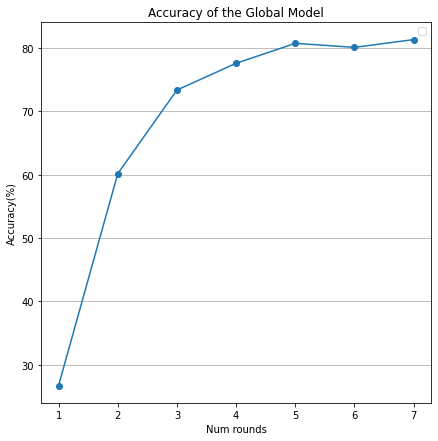

In [49]:
# global_acc_list = [26.716984038791264, 60.15311546396437, 73.3554127190271, 77.58730917267368, 80.73023665495782, 80.09354952848075,  81.32439079295223]

import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Accuracy of the Global Model")
plt.xlabel("Num rounds")
plt.ylabel("Accuracy(%)")

plt.plot(num_round_list, global_acc_list, '-o')
plt.legend()

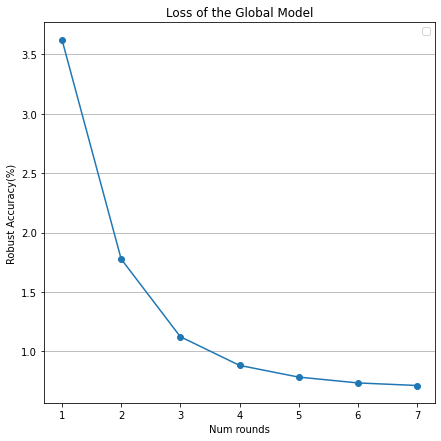

In [46]:
import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Loss of the Global Model")
plt.xlabel("Num rounds")
plt.ylabel("Loss")

plt.plot(num_round_list, glob_loss_list, '-o')
plt.legend()

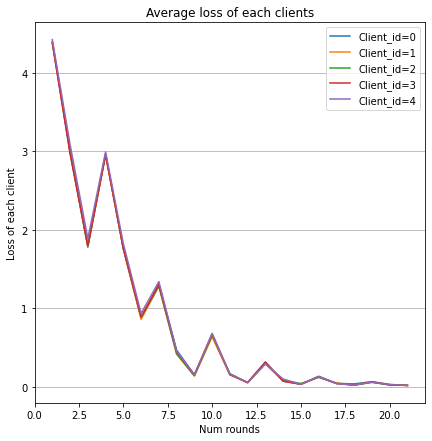

In [47]:
import matplotlib.pyplot as plt

total_iter_per_client = num_local_epochs * num_rounds
client_id_list = list(range(0, num_clients))
total_iter_list = list(range(1, total_iter_per_client+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Average loss of each clients")
plt.xlabel("Num rounds")
plt.ylabel("Loss of each client")

for client_id in client_id_list:
    plt.plot(total_iter_list, id_loss_dict[client_id], label=("Client_id={}".format(client_id)))
    plt.legend()

In [ ]:
import matplotlib.pyplot as plt

total_iter_per_client = num_local_epochs * num_rounds
client_id_list = list(range(0, num_clients))
total_iter_list = list(range(1, total_iter_per_client+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Average loss of each clients")
plt.xlabel("Num rounds")
plt.ylabel("Accuracy(%) of each client")

for client_id in client_id_list:
    plt.plot(total_iter_list, id_acc_dict[client_id], label=("Client_id={}".format(client_id)))
    plt.legend()